In [9]:
# Import necessary libraries
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
# Dataset class for loading images and annotations
class SteelDefectsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = self.img_labels.iloc[idx, 4:8].values
        boxes = boxes.astype(np.float32).reshape(-1, 4)

        labels = self.img_labels.iloc[idx, 3]
        labels = torch.tensor([1 if x == 'crack' else 2 if x == 'scratch' else 3 for x in [labels]])

        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['labels'] = labels

        if self.transform:
            sample = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
            image = sample['image']

        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1), target


In [3]:
# Function to get a model
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [4]:
# Load annotations
train_annotations = pd.read_csv('/content/drive/MyDrive/GP4_Steel Surface Defects_Faster RCNN/train/_annotations.csv')
valid_annotations = pd.read_csv('/content/drive/MyDrive/GP4_Steel Surface Defects_Faster RCNN/valid/_annotations.csv')
test_annotations = pd.read_csv('/content/drive/MyDrive/GP4_Steel Surface Defects_Faster RCNN/test/_annotations.csv')

In [11]:
# Select a subset of annotations for quicker testing
train_annotations = train_annotations.sample(n=400, random_state=42)

# Create datasets and dataloaders
train_dataset = SteelDefectsDataset(train_annotations, '/content/drive/MyDrive/GP4_Steel Surface Defects_Faster RCNN/train')
valid_dataset = SteelDefectsDataset(valid_annotations, '/content/drive/MyDrive/GP4_Steel Surface Defects_Faster RCNN/valid')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


In [12]:
# Define training function
def train_model(num_epochs, model, train_loader, valid_loader, device):
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        lr_scheduler.step()

        print(f"Epoch #{epoch+1} loss: {losses.item()}")

In [7]:
# Initialize the model
model = get_model_instance_segmentation(num_classes=4)  # 3 classes + background

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 167MB/s]


In [13]:
# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_epochs = 3
train_model(num_epochs, model, train_loader, valid_loader, device)


Epoch #1 loss: 0.19925200939178467
Epoch #2 loss: 0.24599511921405792
Epoch #3 loss: 0.21294760704040527


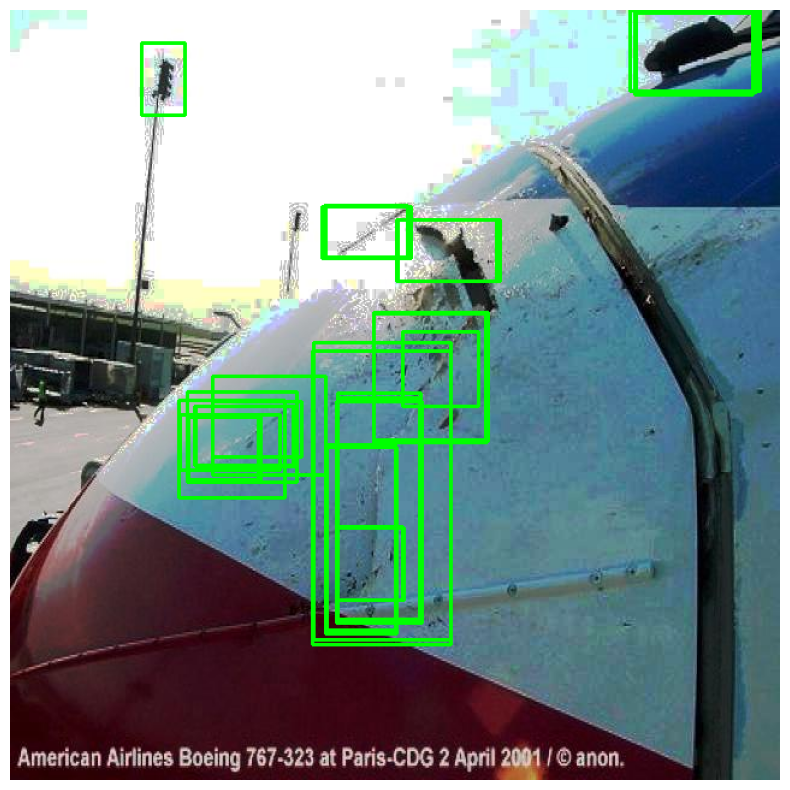

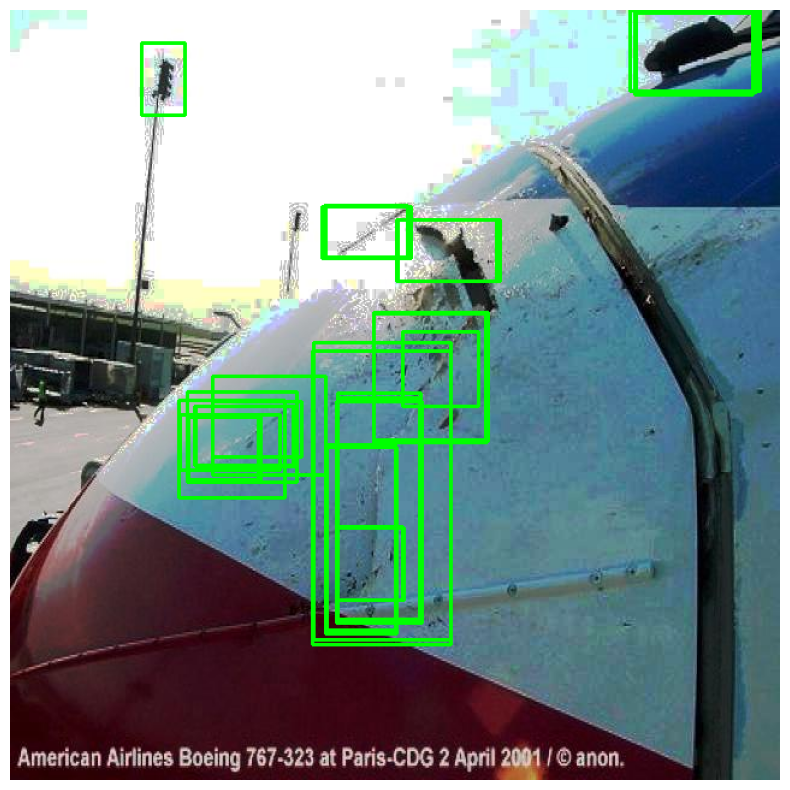

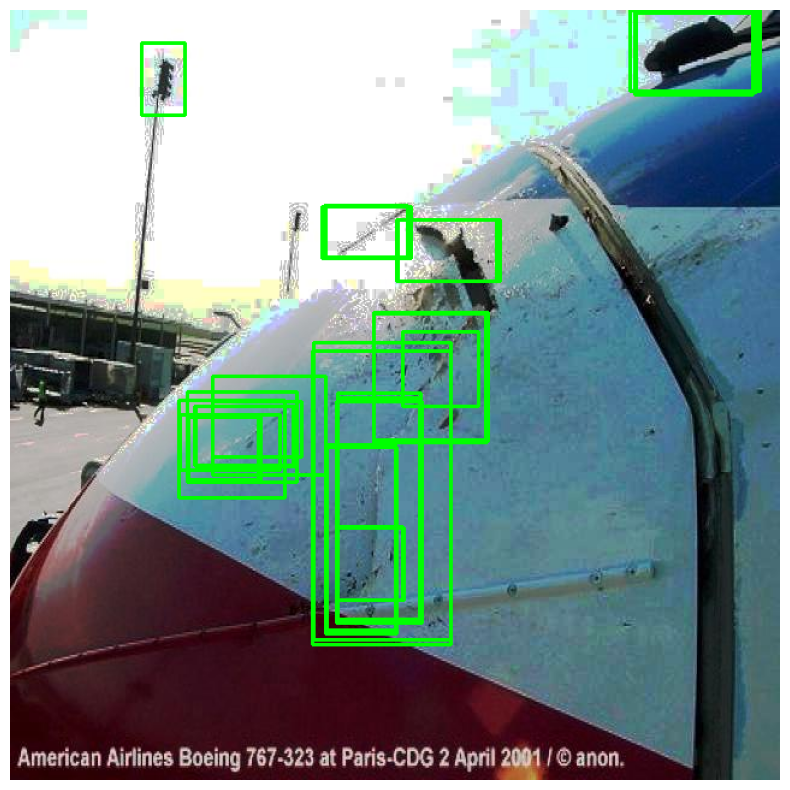

In [15]:
# Test the model on a few validation images
model.eval()
num_images_to_show = 3
images_shown = 0

with torch.no_grad():
    for images, targets in valid_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)
        for i, image in enumerate(images):
            plt.figure(figsize=(10, 10))
            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * 255).astype(np.uint8)  # Convert back to uint8
            for box in outputs[i]['boxes'].cpu().numpy():
                cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            plt.imshow(image_np)
            plt.axis('off')
            plt.show()
            images_shown += 1
            if images_shown >= num_images_to_show:
                break
        if images_shown >= num_images_to_show:
            break


In [17]:
# Example during training loop
torch.save(model.state_dict(), 'model_weights.pth')

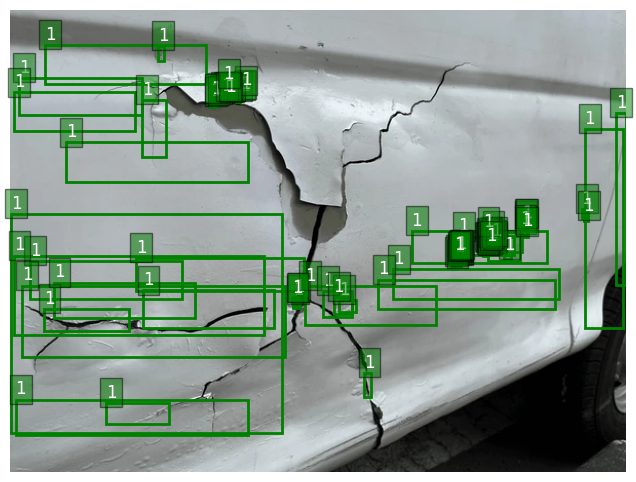

In [19]:
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Function to get a model
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Function to load an image and make predictions
def predict_image(image_path, model, device, threshold=0.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image_rgb).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    # Filter predictions based on score threshold
    scores = predictions[0]['scores'].cpu().numpy()
    mask = scores >= threshold
    boxes = boxes[mask]
    labels = labels[mask]

    return image_rgb, boxes, labels

# Load the trained model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(num_classes=4)  # 3 classes + background

# Replace 'model_weights.pth' with your trained model's weights file path
model.load_state_dict(torch.load('model_weights.pth', map_location=device))
model.to(device)

# Specify the path to your unseen image
image_path = '/content/drive/MyDrive/GP4_Steel Surface Defects_Faster RCNN/steel_predict.jpg'

# Make predictions on the unseen image
image, boxes, labels = predict_image(image_path, model, device, threshold=0.5)

# Plot the image with predictions (smaller size)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = box
    plt.text(xmin, ymin-5, f'{label}', bbox=dict(facecolor='green', alpha=0.5), fontsize=12, color='white')
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='green', linewidth=2))
plt.show()
